## LGMVIP - DS Beginner level task #2: Stock Market Prediction & forcasting using Stacked LSTM 
### Author: Zakaria Jnayni
![02](02.png)

### Load Libraries

In [57]:
import pandas as pd
import numpy as np
from numpy import array
import math
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import calendar

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import LSTM
%matplotlib inline

### Load the dataset

In [78]:
df = pd.read_csv('NSE-TATAGLOBAL.csv')
# df.set_index('Date', inplace=True)
df

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2018-09-28,234.05,235.95,230.20,233.50,233.75,3069914,7162.35
1,2018-09-27,234.55,236.80,231.10,233.80,233.25,5082859,11859.95
2,2018-09-26,240.00,240.00,232.50,235.00,234.25,2240909,5248.60
3,2018-09-25,233.30,236.75,232.00,236.25,236.10,2349368,5503.90
4,2018-09-24,233.55,239.20,230.75,234.00,233.30,3423509,7999.55
...,...,...,...,...,...,...,...,...
2030,2010-07-27,117.60,119.50,112.00,118.80,118.65,586100,694.98
2031,2010-07-26,120.10,121.00,117.10,117.10,117.60,658440,780.01
2032,2010-07-23,121.80,121.95,120.25,120.35,120.65,281312,340.31
2033,2010-07-22,120.30,122.00,120.25,120.75,120.90,293312,355.17


In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2035 entries, 0 to 2034
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Date                  2035 non-null   object 
 1   Open                  2035 non-null   float64
 2   High                  2035 non-null   float64
 3   Low                   2035 non-null   float64
 4   Last                  2035 non-null   float64
 5   Close                 2035 non-null   float64
 6   Total Trade Quantity  2035 non-null   int64  
 7   Turnover (Lacs)       2035 non-null   float64
dtypes: float64(6), int64(1), object(1)
memory usage: 127.3+ KB


### Data visualization 

Text(0, 0.5, 'Prices ($)')

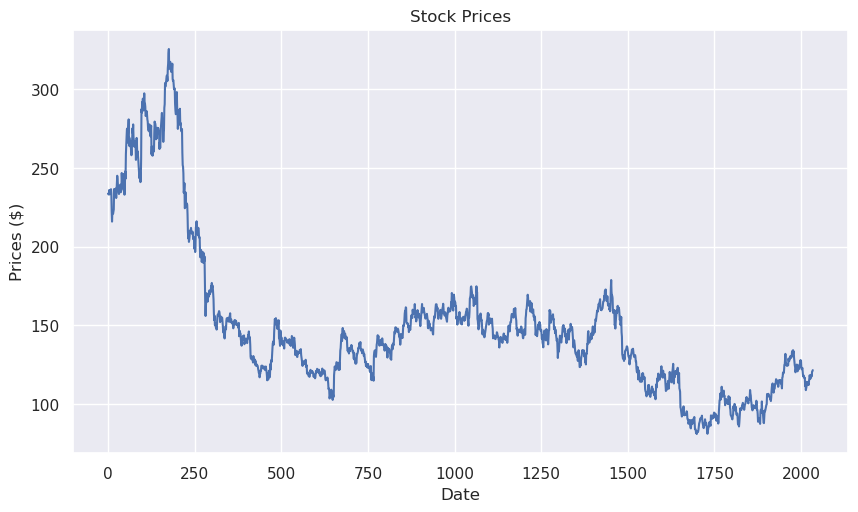

In [79]:
sns.set_theme()
plt.figure(figsize=(10, 5.5))

plt.plot(df['Close'])
plt.title('Stock Prices')
plt.xlabel('Date')
plt.ylabel('Prices ($)')

### Data Preprocessing
We transform the data with MinMax Scaler since  is sensitive

In [84]:
close_prices = df.reset_index()['Close']

In [85]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_prices = scaler.fit_transform(np.array(close_prices).reshape(-1,1))

### Train Test Split

In [86]:
# Train test split
train_size = int(len(scaled_prices)*0.75)
test_size = len(scaled_prices) - train_size
train_data, test_data = scaled_prices[0:train_size,:], scaled_prices[train_size:,:1]

In [87]:
def create_dataset(data, time_step=1):
    x, y = [],[]
    for i in range(len(data)-time_step-1):
        l = data[i:(i+time_step),0]
        x.append(l)
        y.append(data[i+time_step,0])
    return np.array(x),np.array(y)

In [88]:
time_step = 100
x_train, y_train = create_dataset(train_data, time_step)
x_test, y_test = create_dataset(test_data, time_step)

In [90]:
# reshape data for LSTM
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

### LTSM Model Training and validating

In [91]:
model = Sequential()

model.add(LSTM(50, return_sequences=True, input_shape=(100,1)))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [92]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 50)           10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [93]:
model.fit(x_train,y_train, validation_data=(x_test,y_test), epochs=5,batch_size=64, verbose=1)

Epoch 1/5
23/23 [==============================] - 89s 3s/step - loss: 0.0305 - val_loss: 0.0074
Epoch 2/5
23/23 [==============================] - 51s 2s/step - loss: 0.0026 - val_loss: 9.3049e-04
Epoch 3/5
23/23 [==============================] - 54s 2s/step - loss: 0.0017 - val_loss: 0.0020
Epoch 4/5
23/23 [==============================] - 59s 3s/step - loss: 0.0014 - val_loss: 0.0015
Epoch 5/5
23/23 [==============================] - 64s 3s/step - loss: 0.0014 - val_loss: 0.0020


In [102]:
# predict
train_pred = model.predict(x_train)
test_pred = model.predict(x_test)

In [103]:
# transform to orignal
train_pred = scaler.inverse_transform(train_pred)
test_pred = scaler.inverse_transform(test_pred)

In [105]:
from sklearn.metrics import mean_squared_error
# RMSE
np.sqrt(mean_squared_error(y_train, train_pred))
np.sqrt(mean_squared_error(y_test, test_pred))

112.94441187325532

### Visualize the predictions 

In [107]:
look_back = 100
trainPredPlot = np.empty_like(scaled_prices)
trainPredPlot[:, :] = np.nan
trainPredPlot[look_back:len(train_pred) + look_back, :] = train_pred

In [108]:
testPredPlot = np.empty_like(scaled_prices)
testPredPlot[:, :] = np.nan
testPredPlot[len(train_pred) + (look_back*2) + 1 : len(scaled_prices) - 1, :] = test_pred

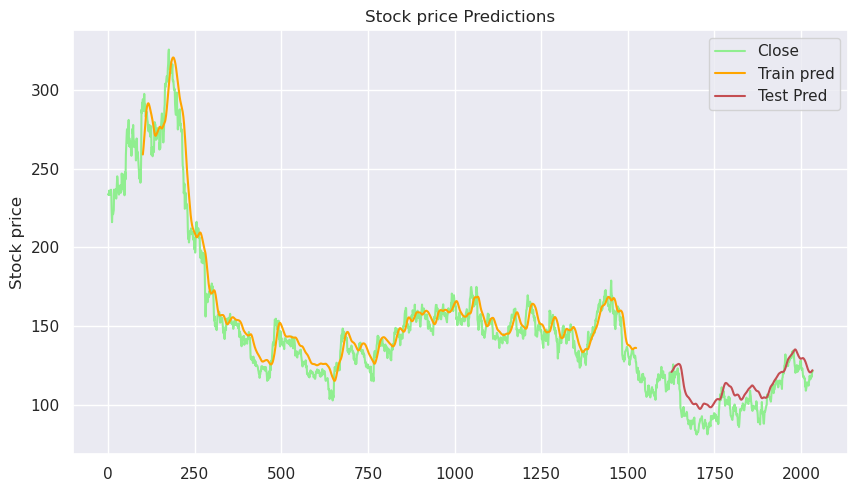

In [126]:
plt.figure(figsize=(10, 5.5))

plt.plot(scaler.inverse_transform(scaled_prices), c='lightgreen')
plt.plot(trainPredPlot, c='orange')
plt.plot(testPredPlot, c='r')
# plt.xlabel('')
plt.ylabel('Stock price')
plt.title('Stock price Predictions')
plt.legend(['Close','Train pred', 'Test Pred'], loc='best')
plt.show();

### Stock Price forcasting for the next 3 Months

In [132]:
len(test_data), x_test.shape

(509, (408, 100, 1))

In [134]:
x_input = test_data[409:].reshape(1,-1)
x_input.shape

(1, 100)

In [47]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [135]:
output = []
n_steps=100
i = 1
while( i <= 120):
    if(len(temp_input) > 100):
        x_input = np.array(temp_input[1:])
        print(f"{i} day input {x_input}")
        x_input = x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        pred = model.predict(x_input, verbose=0)
        print(f"{i} day input {pred}")
        temp_input.extend(pred[0].tolist())
        temp_input = temp_input[1:]
        output.extend(pred.tolist())
        i = i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        pred = model.predict(x_input, verbose=0)
        print(pred[0])
        temp_input.extend(pred[0].tolist())
        print(len(temp_input))
        output.extend(pred.tolist())
        i = i+1

1 day input [0.18913399 0.18954248 0.19403595 0.19444444 0.20200163 0.19771242
 0.19934641 0.19873366 0.1997549  0.2128268  0.21568627 0.20445261
 0.21772876 0.21098856 0.21425654 0.19750817 0.18811275 0.17851307
 0.17381536 0.16033497 0.16564542 0.17116013 0.17422386 0.18035131
 0.17401961 0.16278595 0.16973039 0.17810458 0.17034314 0.16830065
 0.17279412 0.17544935 0.18382353 0.19138072 0.18913399 0.19097222
 0.17238562 0.16830065 0.1693219  0.17177288 0.16156046 0.14971405
 0.1503268  0.15196078 0.14726307 0.14501634 0.14603758 0.12479575
 0.13112745 0.11397059 0.1190768  0.12377451 0.13562092 0.12908497
 0.13459967 0.12806373 0.13031046 0.12724673 0.13521242 0.14522059
 0.15257353 0.14848856 0.14338235 0.14562908 0.15236928 0.15400327
 0.14971405 0.1621732  0.16319444 0.16584967 0.15887347 0.16078578
 0.16266043 0.1644612  0.16617288 0.16779372 0.16933018 0.17079252
 0.17219205 0.17353989 0.17484532 0.17611612 0.17735812 0.17857559
 0.17977145 0.18094771 0.18210557 0.18324567 0.184

8 day input [[0.21641348]]
9 day input [0.1997549  0.2128268  0.21568627 0.20445261 0.21772876 0.21098856
 0.21425654 0.19750817 0.18811275 0.17851307 0.17381536 0.16033497
 0.16564542 0.17116013 0.17422386 0.18035131 0.17401961 0.16278595
 0.16973039 0.17810458 0.17034314 0.16830065 0.17279412 0.17544935
 0.18382353 0.19138072 0.18913399 0.19097222 0.17238562 0.16830065
 0.1693219  0.17177288 0.16156046 0.14971405 0.1503268  0.15196078
 0.14726307 0.14501634 0.14603758 0.12479575 0.13112745 0.11397059
 0.1190768  0.12377451 0.13562092 0.12908497 0.13459967 0.12806373
 0.13031046 0.12724673 0.13521242 0.14522059 0.15257353 0.14848856
 0.14338235 0.14562908 0.15236928 0.15400327 0.14971405 0.1621732
 0.16319444 0.16584967 0.15887347 0.16078578 0.16266043 0.1644612
 0.16617288 0.16779372 0.16933018 0.17079252 0.17219205 0.17353989
 0.17484532 0.17611612 0.17735812 0.17857559 0.17977145 0.18094771
 0.18210557 0.18324567 0.18436849 0.1854742  0.18656299 0.18763497
 0.18869035 0.18972929 0.

16 day input [[0.22960329]]
17 day input [0.18811275 0.17851307 0.17381536 0.16033497 0.16564542 0.17116013
 0.17422386 0.18035131 0.17401961 0.16278595 0.16973039 0.17810458
 0.17034314 0.16830065 0.17279412 0.17544935 0.18382353 0.19138072
 0.18913399 0.19097222 0.17238562 0.16830065 0.1693219  0.17177288
 0.16156046 0.14971405 0.1503268  0.15196078 0.14726307 0.14501634
 0.14603758 0.12479575 0.13112745 0.11397059 0.1190768  0.12377451
 0.13562092 0.12908497 0.13459967 0.12806373 0.13031046 0.12724673
 0.13521242 0.14522059 0.15257353 0.14848856 0.14338235 0.14562908
 0.15236928 0.15400327 0.14971405 0.1621732  0.16319444 0.16584967
 0.15887347 0.16078578 0.16266043 0.1644612  0.16617288 0.16779372
 0.16933018 0.17079252 0.17219205 0.17353989 0.17484532 0.17611612
 0.17735812 0.17857559 0.17977145 0.18094771 0.18210557 0.18324567
 0.18436849 0.1854742  0.18656299 0.18763497 0.18869035 0.18972929
 0.19075197 0.19175865 0.19274956 0.19372505 0.19468535 0.1956308
 0.20686994 0.20789081

24 day input [[0.24166739]]
25 day input [0.17401961 0.16278595 0.16973039 0.17810458 0.17034314 0.16830065
 0.17279412 0.17544935 0.18382353 0.19138072 0.18913399 0.19097222
 0.17238562 0.16830065 0.1693219  0.17177288 0.16156046 0.14971405
 0.1503268  0.15196078 0.14726307 0.14501634 0.14603758 0.12479575
 0.13112745 0.11397059 0.1190768  0.12377451 0.13562092 0.12908497
 0.13459967 0.12806373 0.13031046 0.12724673 0.13521242 0.14522059
 0.15257353 0.14848856 0.14338235 0.14562908 0.15236928 0.15400327
 0.14971405 0.1621732  0.16319444 0.16584967 0.15887347 0.16078578
 0.16266043 0.1644612  0.16617288 0.16779372 0.16933018 0.17079252
 0.17219205 0.17353989 0.17484532 0.17611612 0.17735812 0.17857559
 0.17977145 0.18094771 0.18210557 0.18324567 0.18436849 0.1854742
 0.18656299 0.18763497 0.18869035 0.18972929 0.19075197 0.19175865
 0.19274956 0.19372505 0.19468535 0.1956308  0.20686994 0.20789081
 0.20903483 0.21031159 0.21171023 0.21320961 0.21478531 0.21641348
 0.21807325 0.21974781

32 day input [[0.2526344]]
33 day input [0.18382353 0.19138072 0.18913399 0.19097222 0.17238562 0.16830065
 0.1693219  0.17177288 0.16156046 0.14971405 0.1503268  0.15196078
 0.14726307 0.14501634 0.14603758 0.12479575 0.13112745 0.11397059
 0.1190768  0.12377451 0.13562092 0.12908497 0.13459967 0.12806373
 0.13031046 0.12724673 0.13521242 0.14522059 0.15257353 0.14848856
 0.14338235 0.14562908 0.15236928 0.15400327 0.14971405 0.1621732
 0.16319444 0.16584967 0.15887347 0.16078578 0.16266043 0.1644612
 0.16617288 0.16779372 0.16933018 0.17079252 0.17219205 0.17353989
 0.17484532 0.17611612 0.17735812 0.17857559 0.17977145 0.18094771
 0.18210557 0.18324567 0.18436849 0.1854742  0.18656299 0.18763497
 0.18869035 0.18972929 0.19075197 0.19175865 0.19274956 0.19372505
 0.19468535 0.1956308  0.20686994 0.20789081 0.20903483 0.21031159
 0.21171023 0.21320961 0.21478531 0.21641348 0.21807325 0.21974781
 0.22142428 0.22309339 0.22474907 0.22638717 0.22800559 0.22960329
 0.23118001 0.23273598 0

40 day input [[0.26267746]]
41 day input [0.16156046 0.14971405 0.1503268  0.15196078 0.14726307 0.14501634
 0.14603758 0.12479575 0.13112745 0.11397059 0.1190768  0.12377451
 0.13562092 0.12908497 0.13459967 0.12806373 0.13031046 0.12724673
 0.13521242 0.14522059 0.15257353 0.14848856 0.14338235 0.14562908
 0.15236928 0.15400327 0.14971405 0.1621732  0.16319444 0.16584967
 0.15887347 0.16078578 0.16266043 0.1644612  0.16617288 0.16779372
 0.16933018 0.17079252 0.17219205 0.17353989 0.17484532 0.17611612
 0.17735812 0.17857559 0.17977145 0.18094771 0.18210557 0.18324567
 0.18436849 0.1854742  0.18656299 0.18763497 0.18869035 0.18972929
 0.19075197 0.19175865 0.19274956 0.19372505 0.19468535 0.1956308
 0.20686994 0.20789081 0.20903483 0.21031159 0.21171023 0.21320961
 0.21478531 0.21641348 0.21807325 0.21974781 0.22142428 0.22309339
 0.22474907 0.22638717 0.22800559 0.22960329 0.23118001 0.23273598
 0.23427169 0.23578776 0.23728479 0.23876332 0.24022405 0.24166739
 0.24309379 0.24450365

48 day input [[0.2719209]]
49 day input [0.13112745 0.11397059 0.1190768  0.12377451 0.13562092 0.12908497
 0.13459967 0.12806373 0.13031046 0.12724673 0.13521242 0.14522059
 0.15257353 0.14848856 0.14338235 0.14562908 0.15236928 0.15400327
 0.14971405 0.1621732  0.16319444 0.16584967 0.15887347 0.16078578
 0.16266043 0.1644612  0.16617288 0.16779372 0.16933018 0.17079252
 0.17219205 0.17353989 0.17484532 0.17611612 0.17735812 0.17857559
 0.17977145 0.18094771 0.18210557 0.18324567 0.18436849 0.1854742
 0.18656299 0.18763497 0.18869035 0.18972929 0.19075197 0.19175865
 0.19274956 0.19372505 0.19468535 0.1956308  0.20686994 0.20789081
 0.20903483 0.21031159 0.21171023 0.21320961 0.21478531 0.21641348
 0.21807325 0.21974781 0.22142428 0.22309339 0.22474907 0.22638717
 0.22800559 0.22960329 0.23118001 0.23273598 0.23427169 0.23578776
 0.23728479 0.23876332 0.24022405 0.24166739 0.24309379 0.24450365
 0.24589731 0.24727517 0.24863754 0.2499847  0.25131688 0.25263441
 0.25393754 0.25522655 

56 day input [[0.28046808]]
57 day input [0.13031046 0.12724673 0.13521242 0.14522059 0.15257353 0.14848856
 0.14338235 0.14562908 0.15236928 0.15400327 0.14971405 0.1621732
 0.16319444 0.16584967 0.15887347 0.16078578 0.16266043 0.1644612
 0.16617288 0.16779372 0.16933018 0.17079252 0.17219205 0.17353989
 0.17484532 0.17611612 0.17735812 0.17857559 0.17977145 0.18094771
 0.18210557 0.18324567 0.18436849 0.1854742  0.18656299 0.18763497
 0.18869035 0.18972929 0.19075197 0.19175865 0.19274956 0.19372505
 0.19468535 0.1956308  0.20686994 0.20789081 0.20903483 0.21031159
 0.21171023 0.21320961 0.21478531 0.21641348 0.21807325 0.21974781
 0.22142428 0.22309339 0.22474907 0.22638717 0.22800559 0.22960329
 0.23118001 0.23273598 0.23427169 0.23578776 0.23728479 0.23876332
 0.24022405 0.24166739 0.24309379 0.24450365 0.24589731 0.24727517
 0.24863754 0.2499847  0.25131688 0.25263441 0.25393754 0.25522655
 0.25650167 0.25776315 0.25901121 0.26024613 0.26146817 0.26267746
 0.26387432 0.2650589  

64 day input [[0.2884053]]
65 day input [0.15236928 0.15400327 0.14971405 0.1621732  0.16319444 0.16584967
 0.15887347 0.16078578 0.16266043 0.1644612  0.16617288 0.16779372
 0.16933018 0.17079252 0.17219205 0.17353989 0.17484532 0.17611612
 0.17735812 0.17857559 0.17977145 0.18094771 0.18210557 0.18324567
 0.18436849 0.1854742  0.18656299 0.18763497 0.18869035 0.18972929
 0.19075197 0.19175865 0.19274956 0.19372505 0.19468535 0.1956308
 0.20686994 0.20789081 0.20903483 0.21031159 0.21171023 0.21320961
 0.21478531 0.21641348 0.21807325 0.21974781 0.22142428 0.22309339
 0.22474907 0.22638717 0.22800559 0.22960329 0.23118001 0.23273598
 0.23427169 0.23578776 0.23728479 0.23876332 0.24022405 0.24166739
 0.24309379 0.24450365 0.24589731 0.24727517 0.24863754 0.2499847
 0.25131688 0.25263441 0.25393754 0.25522655 0.25650167 0.25776315
 0.25901121 0.26024613 0.26146817 0.26267746 0.26387432 0.2650589
 0.26623148 0.26739225 0.26854134 0.26967901 0.27080545 0.27192089
 0.27302542 0.27411929 0.

72 day input [[0.2958049]]
73 day input [0.16266043 0.1644612  0.16617288 0.16779372 0.16933018 0.17079252
 0.17219205 0.17353989 0.17484532 0.17611612 0.17735812 0.17857559
 0.17977145 0.18094771 0.18210557 0.18324567 0.18436849 0.1854742
 0.18656299 0.18763497 0.18869035 0.18972929 0.19075197 0.19175865
 0.19274956 0.19372505 0.19468535 0.1956308  0.20686994 0.20789081
 0.20903483 0.21031159 0.21171023 0.21320961 0.21478531 0.21641348
 0.21807325 0.21974781 0.22142428 0.22309339 0.22474907 0.22638717
 0.22800559 0.22960329 0.23118001 0.23273598 0.23427169 0.23578776
 0.23728479 0.23876332 0.24022405 0.24166739 0.24309379 0.24450365
 0.24589731 0.24727517 0.24863754 0.2499847  0.25131688 0.25263441
 0.25393754 0.25522655 0.25650167 0.25776315 0.25901121 0.26024613
 0.26146817 0.26267746 0.26387432 0.2650589  0.26623148 0.26739225
 0.26854134 0.26967901 0.27080545 0.27192089 0.27302542 0.27411929
 0.27520272 0.27627575 0.27733859 0.27839154 0.27943465 0.28046808
 0.28149202 0.28250653 

80 day input [[0.30272803]]
81 day input [0.17484532 0.17611612 0.17735812 0.17857559 0.17977145 0.18094771
 0.18210557 0.18324567 0.18436849 0.1854742  0.18656299 0.18763497
 0.18869035 0.18972929 0.19075197 0.19175865 0.19274956 0.19372505
 0.19468535 0.1956308  0.20686994 0.20789081 0.20903483 0.21031159
 0.21171023 0.21320961 0.21478531 0.21641348 0.21807325 0.21974781
 0.22142428 0.22309339 0.22474907 0.22638717 0.22800559 0.22960329
 0.23118001 0.23273598 0.23427169 0.23578776 0.23728479 0.23876332
 0.24022405 0.24166739 0.24309379 0.24450365 0.24589731 0.24727517
 0.24863754 0.2499847  0.25131688 0.25263441 0.25393754 0.25522655
 0.25650167 0.25776315 0.25901121 0.26024613 0.26146817 0.26267746
 0.26387432 0.2650589  0.26623148 0.26739225 0.26854134 0.26967901
 0.27080545 0.27192089 0.27302542 0.27411929 0.27520272 0.27627575
 0.27733859 0.27839154 0.27943465 0.28046808 0.28149202 0.28250653
 0.28351185 0.28450808 0.28549546 0.28647399 0.28744391 0.2884053
 0.28935832 0.29030302

88 day input [[0.30922678]]
89 day input [0.18436849 0.1854742  0.18656299 0.18763497 0.18869035 0.18972929
 0.19075197 0.19175865 0.19274956 0.19372505 0.19468535 0.1956308
 0.20686994 0.20789081 0.20903483 0.21031159 0.21171023 0.21320961
 0.21478531 0.21641348 0.21807325 0.21974781 0.22142428 0.22309339
 0.22474907 0.22638717 0.22800559 0.22960329 0.23118001 0.23273598
 0.23427169 0.23578776 0.23728479 0.23876332 0.24022405 0.24166739
 0.24309379 0.24450365 0.24589731 0.24727517 0.24863754 0.2499847
 0.25131688 0.25263441 0.25393754 0.25522655 0.25650167 0.25776315
 0.25901121 0.26024613 0.26146817 0.26267746 0.26387432 0.2650589
 0.26623148 0.26739225 0.26854134 0.26967901 0.27080545 0.27192089
 0.27302542 0.27411929 0.27520272 0.27627575 0.27733859 0.27839154
 0.27943465 0.28046808 0.28149202 0.28250653 0.28351185 0.28450808
 0.28549546 0.28647399 0.28744391 0.2884053  0.28935832 0.29030302
 0.29123965 0.29216826 0.29308894 0.29400191 0.29490715 0.29580489
 0.29669523 0.29757813 0

96 day input [[0.31534588]]
97 day input [0.19274956 0.19372505 0.19468535 0.1956308  0.20686994 0.20789081
 0.20903483 0.21031159 0.21171023 0.21320961 0.21478531 0.21641348
 0.21807325 0.21974781 0.22142428 0.22309339 0.22474907 0.22638717
 0.22800559 0.22960329 0.23118001 0.23273598 0.23427169 0.23578776
 0.23728479 0.23876332 0.24022405 0.24166739 0.24309379 0.24450365
 0.24589731 0.24727517 0.24863754 0.2499847  0.25131688 0.25263441
 0.25393754 0.25522655 0.25650167 0.25776315 0.25901121 0.26024613
 0.26146817 0.26267746 0.26387432 0.2650589  0.26623148 0.26739225
 0.26854134 0.26967901 0.27080545 0.27192089 0.27302542 0.27411929
 0.27520272 0.27627575 0.27733859 0.27839154 0.27943465 0.28046808
 0.28149202 0.28250653 0.28351185 0.28450808 0.28549546 0.28647399
 0.28744391 0.2884053  0.28935832 0.29030302 0.29123965 0.29216826
 0.29308894 0.29400191 0.29490715 0.29580489 0.29669523 0.29757813
 0.2984539  0.29932261 0.30018419 0.30103892 0.3018868  0.30272803
 0.30356258 0.3043906

104 day input [[0.3211239]]
105 day input [0.21171023 0.21320961 0.21478531 0.21641348 0.21807325 0.21974781
 0.22142428 0.22309339 0.22474907 0.22638717 0.22800559 0.22960329
 0.23118001 0.23273598 0.23427169 0.23578776 0.23728479 0.23876332
 0.24022405 0.24166739 0.24309379 0.24450365 0.24589731 0.24727517
 0.24863754 0.2499847  0.25131688 0.25263441 0.25393754 0.25522655
 0.25650167 0.25776315 0.25901121 0.26024613 0.26146817 0.26267746
 0.26387432 0.2650589  0.26623148 0.26739225 0.26854134 0.26967901
 0.27080545 0.27192089 0.27302542 0.27411929 0.27520272 0.27627575
 0.27733859 0.27839154 0.27943465 0.28046808 0.28149202 0.28250653
 0.28351185 0.28450808 0.28549546 0.28647399 0.28744391 0.2884053
 0.28935832 0.29030302 0.29123965 0.29216826 0.29308894 0.29400191
 0.29490715 0.29580489 0.29669523 0.29757813 0.2984539  0.29932261
 0.30018419 0.30103892 0.3018868  0.30272803 0.30356258 0.30439064
 0.30521223 0.30602744 0.30683649 0.3076393  0.3084361  0.30922678
 0.31001157 0.3107904

112 day input [[0.3265943]]
113 day input [0.22474907 0.22638717 0.22800559 0.22960329 0.23118001 0.23273598
 0.23427169 0.23578776 0.23728479 0.23876332 0.24022405 0.24166739
 0.24309379 0.24450365 0.24589731 0.24727517 0.24863754 0.2499847
 0.25131688 0.25263441 0.25393754 0.25522655 0.25650167 0.25776315
 0.25901121 0.26024613 0.26146817 0.26267746 0.26387432 0.2650589
 0.26623148 0.26739225 0.26854134 0.26967901 0.27080545 0.27192089
 0.27302542 0.27411929 0.27520272 0.27627575 0.27733859 0.27839154
 0.27943465 0.28046808 0.28149202 0.28250653 0.28351185 0.28450808
 0.28549546 0.28647399 0.28744391 0.2884053  0.28935832 0.29030302
 0.29123965 0.29216826 0.29308894 0.29400191 0.29490715 0.29580489
 0.29669523 0.29757813 0.2984539  0.29932261 0.30018419 0.30103892
 0.3018868  0.30272803 0.30356258 0.30439064 0.30521223 0.30602744
 0.30683649 0.3076393  0.3084361  0.30922678 0.31001157 0.31079048
 0.31156376 0.31233126 0.3130931  0.31384948 0.31460032 0.31534588
 0.31608602 0.31682095

120 day input [[0.33178642]]


### Visualize the results

In [151]:
final_df = scaled_prices.tolist()
final_df.extend(output)
final_df = scaler.inverse_transform(final_df).tolist()

Text(0.5, 1.0, 'Stock Price for the next 3 Months')

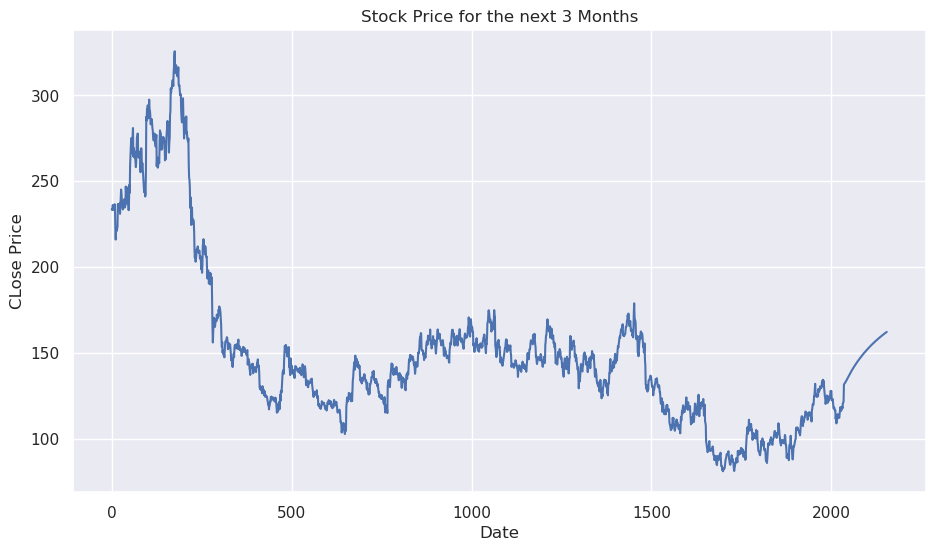

In [154]:
plt.figure(figsize=(11, 6))

plt.plot(final_df)
plt.xlabel('Date')
plt.ylabel('CLose Price')
plt.title('Stock Price for the next 3 Months')